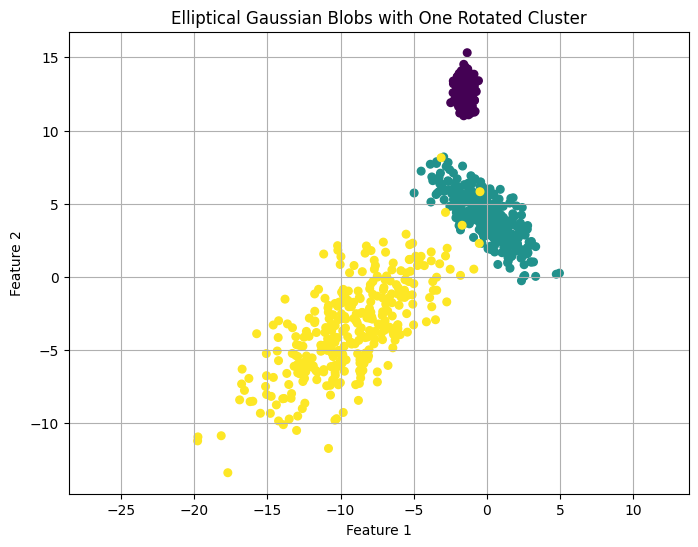

In [15]:
# Both with K-means and GMM we need to stablish the number of clusters for the algorithm
# Rather than manually searching for the optimal number, you can use the Bayesian Gaussian Mixture class
# Let's begin by generating 3 elliptical blobs with rotation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set seed for reproducibility
np.random.seed(42)

# Generate a synthetic dataset of 3 Gaussian blobs in 2D
X, y_true = make_blobs(n_samples=1000,      # Total number of points
                       centers=3,           # Number of clusters
                       cluster_std=[0.5,1.5,3], # Standard deviation of each blob
                       n_features=2)        # Number of features (2D)

# Separate the points by cluster label
X0 = X[y_true == 0]  # Cluster 0
X1 = X[y_true == 1]  # Cluster 1
X2 = X[y_true == 2]  # Cluster 2

# Define a stretching transformation: makes blobs elliptical
stretch = np.array([
    [0.6, 0],    # Scale x-axis
    [0, 1.4]     # Scale y-axis
])

# Define a rotation matrix (45 degrees)
theta1 = np.radians(45)
rotation1 = np.array([
    [np.cos(theta1), -np.sin(theta1)],
    [np.sin(theta1),  np.cos(theta1)]
])

# Define a rotation matrix (45 degrees)
theta2 = np.radians(-45)
rotation2 = np.array([
    [np.cos(theta2), -np.sin(theta2)],
    [np.sin(theta2),  np.cos(theta2)]
])

# Apply transformations:
# - Stretch all clusters
# - Additionally rotate only cluster 1 (to show orientation difference)

X0_transformed = X0 @ stretch.T                        # Just stretched
X1_transformed = X1 @ (rotation1 @ stretch).T          # Rotated and stretched
X2_transformed = X2 @ (rotation2 @ stretch).T          # Rotated and stretched

# Combine all the transformed clusters into one dataset
X_elliptical = np.vstack((X0_transformed, X1_transformed, X2_transformed))

# Recreate the label array to match the new dataset
y_elliptical = np.hstack((
    np.zeros(len(X0)),        # Label 0
    np.ones(len(X1)),         # Label 1
    np.full(len(X2), 2)       # Label 2
))

# Plot the final dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1],
            c=y_elliptical, cmap='viridis', s=30)

plt.title("Elliptical Gaussian Blobs with One Rotated Cluster")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.axis("equal")  # Keep aspect ratio square to show true shape
plt.show()

In [16]:
# We can set the number of clusters n_components to a value greater than the expected
# This assumes that we have some knowledge of the amounts of clusters that may be present in the dataset
# The algorithm will eliminate the unnecessary number clusters automatically
from sklearn.mixture import BayesianGaussianMixture

# Suppress a specific warning from joblib about physical CPU cores
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Initialize a Bayesian Gaussian Mixture model
# - n_components is the upper limit of components the model can use
# - n_init specifies how many times the algorithm will be run with different initializations
bgm = BayesianGaussianMixture(n_components=10, n_init=10)

# Fit the model to the elliptical dataset
# The model will automatically determine how many components are actually needed
bgm.fit(X_elliptical)

# Print the estimated weight (importance) of each component
# Components with very low weights are essentially ignored
print(f"Weight on each possible cluster:\n{np.round(bgm.weights_, 2)}")

Weight on each possible cluster:
[0.34 0.33 0.33 0.   0.   0.   0.   0.   0.   0.  ]


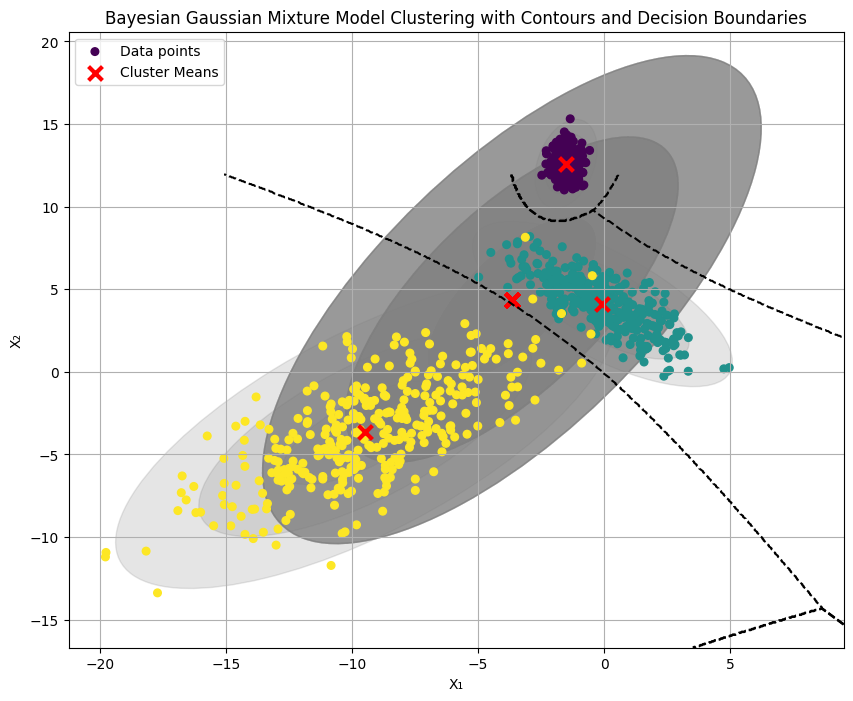

In [19]:
# Let's visualize the dataset and the models means and covariance
from matplotlib.patches import Ellipse

# Create a meshgrid for decision boundaries
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Predict cluster labels for each point in the grid
Z = bgm.predict(grid_points)
Z = Z.reshape(X_grid.shape)

# Create the figure
plt.figure(figsize=(10, 8))

# Plot decision boundaries as dashed contour lines
plt.contour(X_grid, Y_grid, Z, levels=np.unique(Z), colors='k',
            linestyles='dashed', linewidths=1.5)

# Draw ellipses for each GMM component (so they appear behind)
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw 1σ, 2σ, and 3σ ellipses for a Gaussian component."""
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):  # Full covariance matrix
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ell = Ellipse(xy=position, width=nsig * width, height=nsig * height,
                      angle=angle, alpha=0.2, **kwargs)
        ax.add_patch(ell)

# Plot ellipses before data points
for mean, covar in zip(bgm.means_, bgm.covariances_):
    draw_ellipse(mean, covar, color='gray')

# Plot the actual data points (now they show on top of ellipses)
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1],
            c=y_elliptical, s=30, cmap='viridis', label='Data points')

# Plot the cluster centers
plt.scatter(bgm.means_[:, 0], bgm.means_[:, 1],
            c='red', marker='x', s=100, linewidths=3, label='Cluster Means')

# Labels and styling
plt.title("Bayesian Gaussian Mixture Model Clustering with Contours and Decision Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# The clusters detected are actually 4, but last of them have a very small weight
print(f"Weight on each possible cluster:\n{bgm.weights_}")

Weight on each possible cluster:
[3.36374214e-01 3.30394392e-01 3.33131950e-01 9.04037804e-05
 8.21851067e-06 7.47137334e-07 6.79215758e-08 6.17468871e-09
 5.61335337e-10 5.10304852e-11]


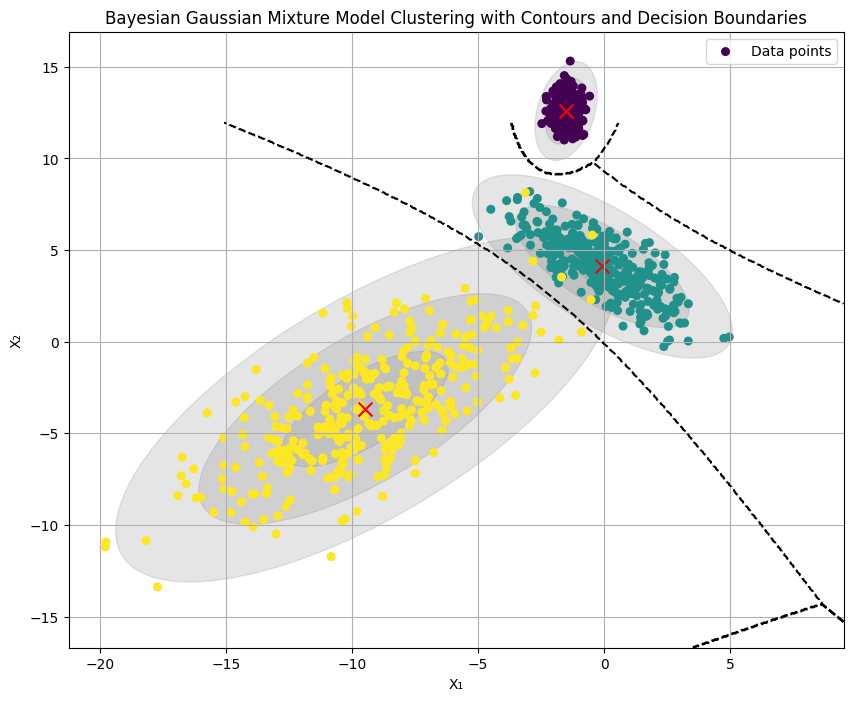

In [27]:
# Let's plot only active clusters
# Choose a threshold for "active" components (e.g., >1% weight)
active = bgm.weights_ > 0.01

# Filter means and covariances
active_means = bgm.means_[active]
active_covs = bgm.covariances_[active]

# Create a new figure for the plot, with a specific size
plt.figure(figsize=(10, 8))

# Plot the decision boundaries for each cluster
# - 'Z' contains predicted cluster labels for each point on the grid
# - Contour lines are dashed and black to show separation between clusters
plt.contour(X_grid, Y_grid, Z,
            levels=np.unique(Z),           # One contour per unique cluster label
            colors='k',
            linestyles='dashed',
            linewidths=1.5)

# Draw ellipses representing the covariance of each "active" Gaussian component
# - These ellipses are plotted *before* the data points so they stay in the background
for mean, cov in zip(active_means, active_covs):
    draw_ellipse(mean, cov, color='gray')

# Scatter plot of the data points from the elliptical dataset
# - Each point is colored based on its original label for visualization
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1],
            c=y_elliptical,        # Color by original cluster label
            s=30,                  # Size of each point
            cmap='viridis',       # Colormap for visual distinction
            label='Data points')  # Legend label

# Plot the centers (means) of the active clusters
# - Red 'X' markers clearly show where the algorithm has found cluster centers
plt.scatter(active_means[:, 0], active_means[:, 1],
            c='red', marker='x', s=100)  # Large red X for cluster means

# Labels and styling
plt.title("Bayesian Gaussian Mixture Model Clustering with Contours and Decision Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.show()